In [316]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [317]:
# Import Data
df = pd.read_csv('Data_Benzene_copie_n.csv', sep=";", header=None)
df.shape
#df = (df.interpolate(axis=1))
grid_shape = (9,8)

In [318]:
df.rename(columns={0: 'benzene', 1: 'eq_ratio'}, inplace=True)
benz = df.iloc[:,0].to_numpy()
phi = df.iloc[:,1].to_numpy()

In [319]:
from sklearn.preprocessing import StandardScaler
T = df.iloc[:,2:].to_numpy()
T_std = StandardScaler().fit(T).transform(T)

Text(0, 0.5, 'Variance ratio')

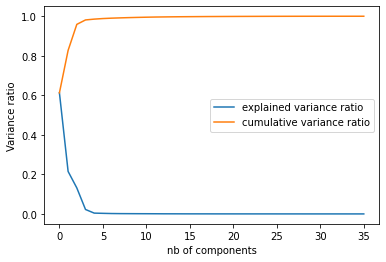

In [337]:
from sklearn.decomposition import PCA
index = 0
pca = PCA(n_components=36)
pca.fit(T_std)


explained_var_ratio = pca.explained_variance_ratio_
#plt.plot(explained_var_ratio)
#plt.show()


# plot of the explained variance by PCs and the cumulative variance ratio :  3 comp. explain up to 80% of the total variance
plt.plot(explained_var_ratio, label = "explained variance ratio")
plt.plot(np.cumsum(explained_var_ratio),label = "cumulative variance ratio")
plt.legend(loc="center right")
plt.xlabel('nb of components')
plt.ylabel('Variance ratio')

Text(0, 0.5, 'variance %')

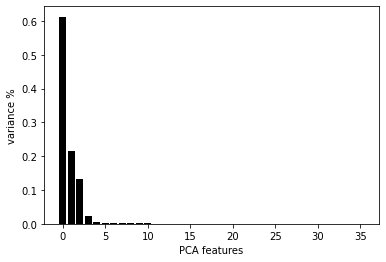

In [338]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
#plt.xticks(features)

In [339]:
A = pca.components_.T
Z = T_std@A # X*A
X_reconstructed = Z[:,:36]@A[:,:36].T

In [340]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

r2 = r2_score(T_std, X_reconstructed)
rmse = sqrt(mean_squared_error(T_std, X_reconstructed))
print(r2)

1.0


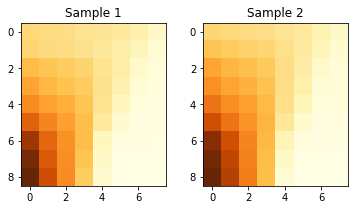

In [341]:
n_pcs = 2
fig, axs = plt.subplots(1,n_pcs, figsize=(3*n_pcs, 3))
for i, ax in enumerate(axs):
    ax.imshow(np.flip(T[i,:].reshape(grid_shape),axis=0), cmap='YlOrBr')
    ax.set_title('Sample ' + str(i+1))

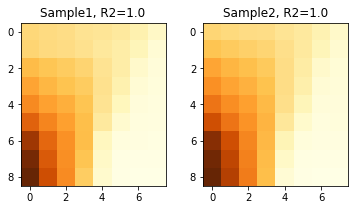

In [342]:
X_rec =  (X_reconstructed*np.std(T,axis=0))+ np.mean(T,axis=0)
n_pcs = 2
fig, axs = plt.subplots(1,n_pcs, figsize=(3*n_pcs, 3))
for i, ax in enumerate(axs):
    ax.imshow(np.flip(X_rec[i,:].reshape(grid_shape),axis=0), cmap='YlOrBr') 
    ax.set_title('Sample' + str(i+1) + ', R2='+ str(np.round(r2,2)))
plt.savefig("36PCs_R2.png", dpi=72)        

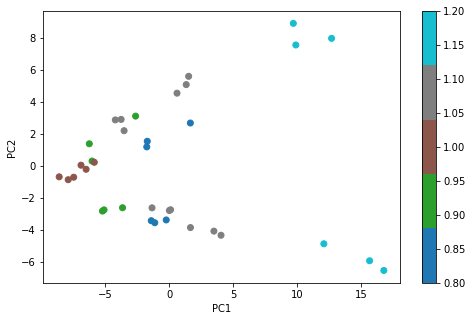

In [326]:
fig, ax = plt.subplots(figsize=(8,5))
im = ax.scatter(Z[:,0], Z[:,1],c=phi, cmap=plt.cm.get_cmap('tab10', 5), alpha=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.colorbar(im)
plt.show()

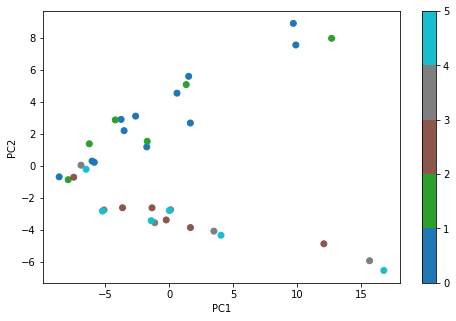

In [327]:
fig, ax = plt.subplots(figsize=(8,5))
im = ax.scatter(Z[:,0], Z[:,1],c=benz, cmap=plt.cm.get_cmap('tab10', 5), alpha=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.colorbar(im)
plt.show()

5


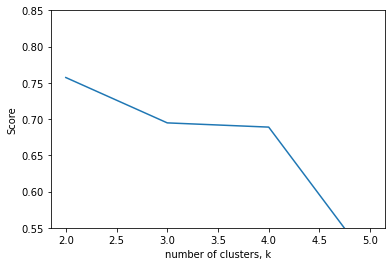

In [328]:
from sklearn.metrics import davies_bouldin_score

k_array = np.arange(2,6)
db_score_array = np.zeros((k_array.size,))
for i,k in enumerate(k_array):
    kmeans = KMeans(n_clusters = k, init = 'random')
    kmeans.fit(Z)
    labels = kmeans.labels_
    db_score_array[i] = davies_bouldin_score(Z, labels)
    
n_clusters = k_array[np.argmin(db_score_array)]
print(n_clusters)

plt.ylim(0.55,0.85)
plt.xlabel('number of clusters, k')
plt.ylabel('Score')
plt.plot(k_array,db_score_array)
plt.show()

In [329]:
kmeans  = KMeans(n_clusters=4,init='random')
kmeans.fit(Z)
labels = kmeans.labels_
print(labels)
#print(Z.shape)

[3 0 3 1 0 0 3 0 3 1 0 0 3 0 3 1 0 0 3 0 3 2 3 0 3 0 3 2 3 0 3 0 3 2 3 0]


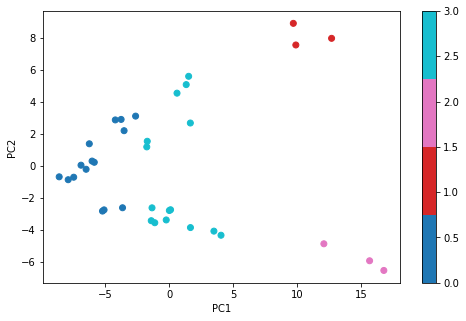

In [330]:
fig, ax = plt.subplots(figsize=(8,5))
im = ax.scatter(Z[:,0], Z[:,1],c=labels, cmap=plt.cm.get_cmap('tab10', 4), alpha=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.colorbar(im)
plt.show()

In [334]:
value_list = [0,0,0,0]
value_counter = [0,0,0,0]

for i in range(T_std.shape[0]):

    Z_biensur = T_std[i][:]@A
    pos = kmeans.predict(Z_biensur.reshape(1,-1))[0]
    value_list[pos]  += np.mean(T[i][:])
    value_counter[pos] += 1

temp_list = []
for it,elem in enumerate(value_list) :
    value = elem/value_counter[it]
    temp_list.append(value)
    print(f"Cluster {it} : {elem/value_counter[it]}")

Cluster 0 : 1179.6214112697949
Cluster 1 : 1080.7012865554823
Cluster 2 : 1068.2125358360233
Cluster 3 : 1145.3987617488688


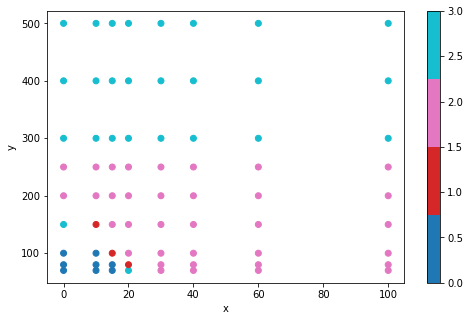

In [336]:
x_list = [0, 10, 15, 20, 30, 40, 60, 100]
y_list = [70, 80, 100, 150, 200 ,250,300,400,500]

line = T[33][:]

associated_cluster=[]

for it,elem in enumerate(line) :
     associated_cluster.append(temp_list.index(min(temp_list, key=lambda x:abs(x-elem))))


list_x = []
list_y = []

for i in range(len(associated_cluster)):
     list_x.append(x_list[i%len(x_list)])
     list_y.append(y_list[int(i/len(x_list))])

fig, ax = plt.subplots(figsize=(8,5))
im = ax.scatter(list_x, list_y,c=associated_cluster, cmap=plt.cm.get_cmap('tab10', 4), alpha=1)
plt.xlabel('x')
plt.ylabel('y')
fig.colorbar(im)
plt.savefig("clustering.png", dpi=72) 
plt.show()

# PCR

In [353]:
df2 = pd.read_csv('RegressionNAN.csv', sep=",")

X = np.array(df2.iloc[:,:4])
Y = np.array(df2.iloc[:,4])

In [356]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# create the test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scale and center the data
scalerX = StandardScaler()

X0_train = scalerX.fit_transform(X_train)
X0_test = scalerX.transform(X_test)

(519, 4)


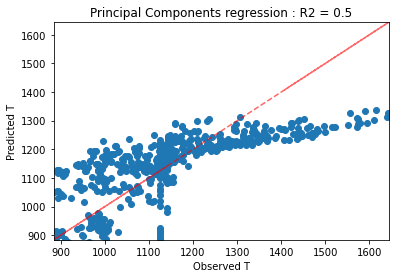

PCR score: 0.5


In [358]:
pca = PCA().fit(X0_train)
A0_train = pca.components_.T
Z0_train = X0_train @ A0_train
Z0_test = X0_test @ A0_train

# The regression has to be applied to the PC scores
PCR_reg = LinearRegression().fit(Z0_train, y_train)

y_pred_PCR = PCR_reg.predict(Z0_test)
print(Z0_test.shape)
plt.scatter(y_test, y_pred_PCR)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed T')
plt.ylabel('Predicted T')
plt.title("Principal Components regression : R2 = 0.5")
plt.savefig("PCR.png", dpi=72) 
plt.show()

#print('LS coefficients: ')
#print(np.round(LS_reg.coef_, 3))

#print('PCR coefficients: ')
#print(np.round(PCR_reg.coef_, 3))

PCR_score = PCR_reg.score(Z0_test, y_test)

#print('LS score: ' + str(np.round(LS_score,2)))
print('PCR score: ' + str(abs(np.round(PCR_score,2))))